<a href="https://colab.research.google.com/github/Vishal487/NLP-movies-review/blob/master/Text_Classification_with_preprocessed_text_Movie_reeviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook classifies movie reviews as positive or negative using the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

We'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

Refer:- https://www.tensorflow.org/tutorials/keras/text_classification

In [ ]:
!pip install -q tf-nightly
import tensorflow as tf

     |████████████████████████████████| 517.7MB 25kB/s 
     |████████████████████████████████| 3.0MB 47.2MB/s 
     |████████████████████████████████| 460kB 42.8MB/s 


In [ ]:
from tensorflow import keras

import tensorflow_datasets as tfds

import numpy as np

print(tf.__version__)

2.2.0-dev20200409


## Download the IMDB  dataset

In [ ]:
(train_data, test_data), info = tfds.load(
    # use the version pre-encode with an ~8k vocabulary
    'imdb_reviews/subwords8k',
    # return the train/test dataset as a tuple,
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # return (example, label) pairs from the dataset (instead of a dictionary)
    as_supervised = True,
    # also return the 'info' structure
    with_info=True
)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteP07PYT/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteP07PYT/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteP07PYT/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Try the encoder
The dataset info includes the text encoder (a https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).



In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('vocavulary size: {}'.format(encoder.vocab_size))

vocavulary size: 8185


In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string is "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string is "Hello TensorFlow."


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [ ]:
for ts in encoded_string:
    print('{} -----> {}'.format(ts, encoder.decode([ts])))

4025 -----> Hell
222 -----> o 
6307 -----> Ten
2327 -----> sor
4043 -----> Fl
2120 -----> ow
7975 -----> .


## Explore the data
Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review.

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary.

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Here's what the first 2 review looks like:

In [ ]:
for train_example, train_label in train_data.take(2):
    print('Encoded text: ', train_example[:10].numpy())
    print('Label: ',train_label.numpy())
    print('Actual text: ',encoder.decode(train_example[:10]))

Encoded text:  [  62   18   41  604  927   65    3  644 7968   21]
Label:  0
Actual text:  This was an absolutely terrible movie. Don't 
Encoded text:  [  12   31   93  867    7 1256 6585 7961  421  365]
Label:  0
Actual text:  I have been known to fall asleep during films


## Prepare the data for training

We want to create batches of training data for our model. **The reviews are all different lengths**, so using `padded_batch` to zero pad the sequences while batching:

In [ ]:
BUUFFER_SIZE = 1000

train_batches = (
    train_data.shuffle(BUUFFER_SIZE).padded_batch(32, padded_shapes=([None],[]))
)

test_batches = (
    test_data.padded_batch(32, padded_shapes=([None],[]))
)

**Note:** As of TensorFlow 2.2 the `padded_shapes` argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [ ]:
# so recreate batches

train_batches = (
    train_data.shuffle(BUUFFER_SIZE).padded_batch(32)
)

test_batches = (
    test_data.padded_batch(32)
)

Each batch will have a shape of `(batch_size, sequence_length)` because the **padding is dynamic each batch will have a different length:**

In [ ]:
# check the shape of batch

for example_batch, label_batch in train_batches.take(2):
    print('Batch shape: ', example_batch.shape)
    print('Label batch: ', label_batch.shape)

Batch shape:  (32, 1023)
Label batch:  (32,)
Batch shape:  (32, 736)
Label batch:  (32,)


## Build the model
The neural network is created by stacking layers—this requires two main architectural decisions:

* How many **layers** to use in the model?
* How many **hidden units** to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a **Continuous bag of words** style model for this problem:

In [ ]:
model = keras.Sequential([
                          keras.layers.Embedding(encoder.vocab_size, 16),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


## Loss function and Optimizer

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    valdation_steps=30)

Epoch 1/10
782/782 [==============================] - 10s 13ms/step - loss: 0.6809 - accuracy: 0.5007 - val_loss: 0.6591 - val_accuracy: 0.5096
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 0.6169 - accuracy: 0.5573 - val_loss: 0.5850 - val_accuracy: 0.6359
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 0.5381 - accuracy: 0.6689 - val_loss: 0.5174 - val_accuracy: 0.7265
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 0.4710 - accuracy: 0.7560 - val_loss: 0.4640 - val_accuracy: 0.7742
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 0.4207 - accuracy: 0.8024 - val_loss: 0.4236 - val_accuracy: 0.8093
Epoch 6/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3788 - accuracy: 0.8346 - val_loss: 0.3936 - val_accuracy: 0.8096
Epoch 7/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3475 - accuracy: 0.8525 - val_loss: 0.3709 - val_accuracy:

## Evaluate the model

In [ ]:
loss, acc = model.evaluate(test_batches)

print('Loss: ', loss)
print('Accuracy: ', acc)

782/782 [==============================] - 3s 4ms/step - loss: 0.3313 - accuracy: 0.8594
Loss:  0.33133700489997864
Accuracy:  0.85944002866745


## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a `dictionary` with everything that happened during time:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

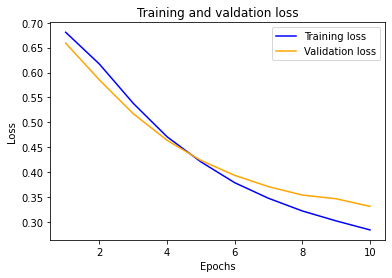

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and valdation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

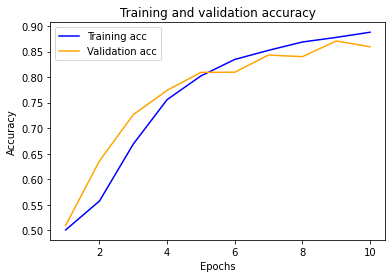

In [ ]:
plt.clf()    # clear figure

plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()